Author: Jonathan Hernandez
Email: jayhernandez1987@gmail.com

This project is to look at world cities and global firms using 2-mode network analysis and the island method to examine firms/industries with alot of weight that is most locations in the world

Data: http://www.lboro.ac.uk/gawc/data.html
Download zip file: 
http://vlado.fmf.uni-lj.si/pub/networks/data/2mode/cities.zip

Citation:
Vladimir Batagelj and Andrej Mrvar (2006): Pajek datasets.
<URL: http://vlado.fmf.uni-lj.si/pub/networks/data/>

Also see the Acknowledgement section:
http://www.lboro.ac.uk/gawc/datasets/da6.html

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter # counting groups in the islands

Read dataset

In [11]:
world_cities_global_firms = pd.read_csv("da6.csv", header=0, skiprows=1, index_col = 0)

Remove total officies (based on cities); matrix will be converted to a 1-mode matrix of firms as nodes
Also extract the cities

In [12]:
world_cities_global_firms = world_cities_global_firms.drop('Unnamed: 47',1)
firms = list(world_cities_global_firms.columns)

In [13]:
print world_cities_global_firms

                KP  CL  EY  AA  PW  GR  DM  LH  SS  TH ...  DW  GJ  HH  JD  \
CITIES                                                 ...                   
Amsterdam        3   3   1   1   3   1   1   1   1   1 ...   0   0   0   0   
Atlanta          3   3   2   2   2   0   0   0   0   1 ...   0   0   0   3   
Bangkok          1   1   1   2   2   1   1   0   1   1 ...   0   1   0   0   
Barcelona        1   1   1   1   2   1   1   1   1   1 ...   0   0   0   0   
Beijing          1   1   1   1   2   0   1   0   1   1 ...   0   1   0   0   
Berlin           2   3   2   2   1   0   0   0   0   0 ...   0   0   0   0   
Boston           3   3   2   1   1   0   0   0   0   0 ...   0   0   0   0   
Brussels         2   3   3   1   3   1   1   1   1   1 ...   1   0   1   2   
Budapest         1   2   1   1   1   0   1   1   1   1 ...   0   0   1   0   
Buenos Aires     2   2   1   1   1   1   1   0   1   1 ...   0   0   0   0   
Caracas          2   1   2   1   1   1   1   1   1   1 ...   0  

Create firm mapping to type of industry firm deals with (hardcoded for now; future imporovement would make it more automated and properly coded.

In [14]:
data = open('da6+.net', 'ro') # dataset containing the metadata as well as industry each firm is in
lines = data.readlines()
firm_industry = {}

for i in lines[59:64]:
    firm_industry[i[5:7]] = "Accountancy"

for i in lines[65:76]:
    firm_industry[i[5:7]] = "Advertising"
    
for i in lines[77:91]:
    firm_industry[i[5:7]] = "Banking and Finance"

for i in lines[92:108]:
    firm_industry[i[5:7]] = "Law"

Convert the matrix from a 2-mode to a 1-mode (nodes are firms and a edge between them is a world city those two firms have in common are located in)

In [15]:
world_cities_adjmatrix = np.matmul(np.transpose(world_cities_global_firms),world_cities_global_firms)

Make a dataset out of this 1-mode matrix and make a graph out of it and print it's information

In [16]:
world_cities = pd.DataFrame(data=world_cities_adjmatrix, index=firms, columns=firms)
G = nx.from_pandas_adjacency(world_cities)
print nx.info(G)

Name: 
Type: Graph
Number of nodes: 46
Number of edges: 1081
Average degree:  47.0000


set node attribute for each firm; attribute is the industry per firm_mapping dict
also graph the entire network to see what we have

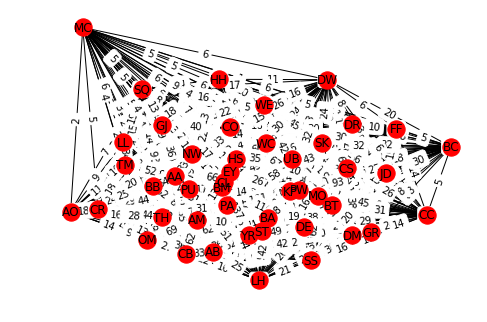

In [17]:
nx.set_node_attributes(G,firm_industry, 'industry')
pos = nx.spring_layout(G)
plt.close()
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels = {(u,v): d['weight'] for u,v,d in G.edges(data=True)})
plt.show()

Let's now use the island method presented in the "Social Network Analysis for Startups (2011) Chapter 4 and examing connected components and threshold levels and how many nodes are left.

1 46 {'Law': 16, 'Banking and Finance': 13, 'Advertising': 11, 'Accountancy': 5}


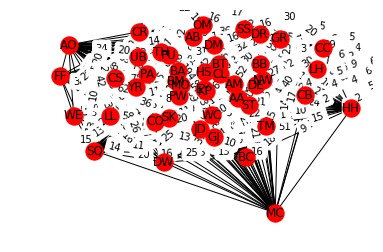

64 32 {'Law': 5, 'Banking and Finance': 11, 'Advertising': 10, 'Accountancy': 5}


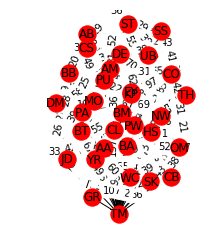

127 16 {'Law': 1, 'Banking and Finance': 6, 'Advertising': 4, 'Accountancy': 5}


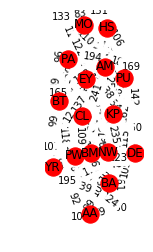

190 8 {'Law': 1, 'Banking and Finance': 2, 'Advertising': 1, 'Accountancy': 4}


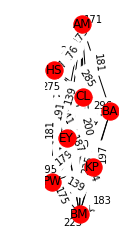

253 4 {'Law': 1, 'Accountancy': 3}


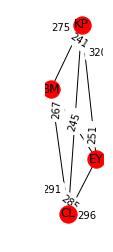

316 1 {'Law': 1}


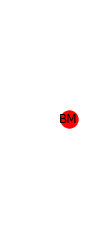

In [18]:
# island method (Per Social Network Analysis for Startups 2nd edition)
# first trim edges
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for from_node, to_node, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(from_node,to_node,weight=edata['weight'])
    return g2


def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

islands= island_method(G) # you'll realize there is only one component after the matrix multiplication
j = 1
for i in islands:
# print the threshold level, size of the graph and number of types of firms for each one
    subgraph= G.subgraph(i[1])
    print i[0], len(i[1]), dict(Counter(nx.get_node_attributes(subgraph,'industry').values()))
    plt.subplot(1,j,1)
    nx.draw(subgraph, pos=nx.spring_layout(subgraph), with_labels=True)
    nx.draw_networkx_edge_labels(subgraph, pos=nx.spring_layout(subgraph), edge_labels = {(u,v): d['weight'] for u,v,d in subgraph.edges(data=True)})
    plt.show()
    j = j + 1

There is only one connected component and thus a strongly connected graph
Looking at the thresholds for say a weight of 127 (number of cities) we can examine
the firms that are stationed at the most cities.

We see that for any threshold of sum of weights/edges that the Law industry is always
there and popular in most world cities. For each threshold the Law nodes decrease but
have the most weight in the graph.

Accounting is also popular but for the threshold levels is the smallest component followed
by Advertising and then Banking and Finance.

I wanted to show the island method and show some visualization and even though converting a 2-mode network into a 1-mode network makes a complete graph a single connected component, we can at least see subgraphs in the original graph.